# Introduction

Hello, I'm **Wesley**, nice to meet you! 👋

While I was making my **[Angry Birds Classifier](https://www.kaggle.com/code/wesleyacheng/angry-birds-classifier)** to classify if tweets are angry or not, I thought why don't we add **2** more emotions! **Joy and Sadness** into the mix!

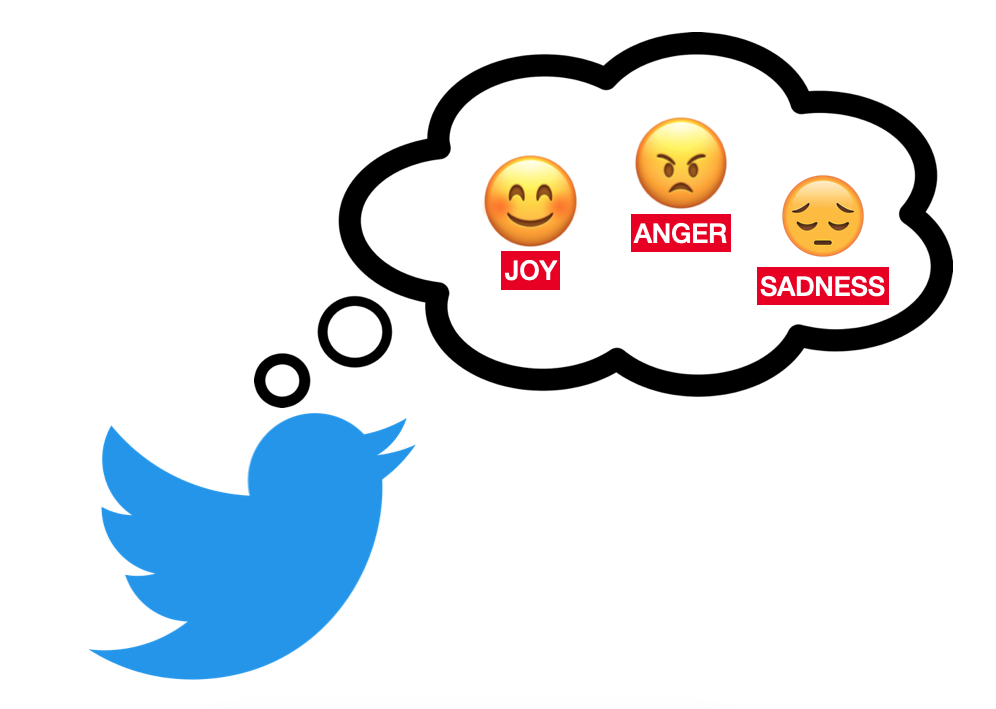

Here we will be creating a **Multiclass Text Classifier** that classifies tweets as either having **JOY, SADNESS, or ANGER**.

We will use the [Twitter Emotion Dataset](https://huggingface.co/datasets/tweet_eval/viewer/emotion/train) and [BERT](https://huggingface.co/distilbert-base-uncased) to do [Transfer Learning](https://en.wikipedia.org/wiki/Transfer_learning) with [PyTorch](https://pytorch.org) and [HuggingFace](https://huggingface.co).

# Setup Python Libraries with pip 🤫

In [1]:
%%bash
pip install numpy torch datasets transformers~=4.28.0 evaluate tqdm --quiet
pip freeze | grep -E '^numpy|^torch|^datasets|^transformers|^evaluate'

datasets==2.1.0
evaluate==0.4.0
numpy==1.23.5
torch @ file:///tmp/torch/torch-2.0.0-cp310-cp310-linux_x86_64.whl#sha256=3a7abcaa5ae70fd4eb83c2cc43abc8ba94995316c6433e171d7454f107d41b58
torchaudio @ file:///tmp/torch/torchaudio-2.0.1-cp310-cp310-linux_x86_64.whl#sha256=83e258b68459f1ff64301c19c2fc791a692fd372271abeef8414854aafd03b06
torchdata==0.6.0
torchinfo==1.8.0
torchmetrics==0.11.4
torchtext @ file:///tmp/torch/torchtext-0.15.1-cp310-cp310-linux_x86_64.whl#sha256=110ca71f44e505c040ea2f41dcaf798cd7de1b55cbedaa6687b9e21eec759844
torchvision @ file:///tmp/torch/torchvision-0.15.1-cp310-cp310-linux_x86_64.whl#sha256=3b0e4e01ab713c145b7e20684eb79f983e75c8c13034901f21e3e8a36a1b3292
transformers==4.28.1


# Create the Twitter Emotion Dataset

## Clone dataset from HuggingFace Hub

In [2]:
from datasets import load_dataset

# let's get the twitter emotion dataset: https://huggingface.co/datasets/tweet_eval/viewer/emotion/train
raw_datasets = load_dataset('tweet_eval', 'emotion')
raw_datasets

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3257 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1421 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/374 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/emotion/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1421
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 374
    })
})

## Check out some examples

In [3]:
# let's print out 5 examples with respective labels
id2label = {0:'ANGER',1:'JOY',2:'OPTIMISM',3:'SADNESS'}
for i in range(5):
    print(f"TEXT[{i}]: {raw_datasets['train']['text'][i]}")
    print(f"LABEL[{i}]: {id2label[raw_datasets['train']['label'][i]]}")
    print()

TEXT[0]: “Worry is a down payment on a problem you may never have'.  Joyce Meyer.  #motivation #leadership #worry
LABEL[0]: OPTIMISM

TEXT[1]: My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs
LABEL[1]: ANGER

TEXT[2]: No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu
LABEL[2]: JOY

TEXT[3]: Rooneys fucking untouchable isn't he? Been fucking dreadful again, depay has looked decent(ish)tonight
LABEL[3]: ANGER

TEXT[4]: it's pretty depressing when u hit pan on ur favourite highlighter
LABEL[4]: SADNESS



## Remove unused emotions

In [4]:
# remove optimism as it's similar to joy
datasets = raw_datasets.filter(lambda row: row['label']!=2)
datasets

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2963
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1298
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 346
    })
})

In [5]:
# let's print out 5 examples without optimism data points
id2label = {0:'ANGER',1:'JOY',2:'OPTIMISM',3:'SADNESS'}
for i in range(5):
    print(f"TEXT[{i}]: {datasets['train']['text'][i]}")
    print(f"LABEL[{i}]: {id2label[datasets['train']['label'][i]]}")
    print()

TEXT[0]: My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs
LABEL[0]: ANGER

TEXT[1]: No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu
LABEL[1]: JOY

TEXT[2]: Rooneys fucking untouchable isn't he? Been fucking dreadful again, depay has looked decent(ish)tonight
LABEL[2]: ANGER

TEXT[3]: it's pretty depressing when u hit pan on ur favourite highlighter
LABEL[3]: SADNESS

TEXT[4]: @user but your pussy was weak from what I heard so stfu up to me bitch . You got to threaten him that your pregnant .
LABEL[4]: ANGER



## Get the Fast BERT Tokenizer

In [6]:
from transformers import AutoTokenizer

# let's use the fast bert tokenizer
checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)

tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

## Tokenize Tweets

In [7]:
def tokenization(batch):
    tokenized_batch = tokenizer(batch['text'], truncation=True)
    # map SADNESS target label from 3 to 2
    tokenized_batch['label'] = [2 if label==3 else label for label in batch['label']]
    return tokenized_batch

# tokenize each text
tokenized_datasets = datasets.map(tokenization, batched=True, remove_columns=['text'])
# rename target variable 'label' to 'labels'
tokenized_datasets = tokenized_datasets.rename_column('label', 'labels')
# set to pytorch
tokenized_datasets.set_format('torch')

tokenized_datasets

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 2963
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1298
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 346
    })
})

## Checkout some Tokenized Tweets

In [8]:
# let's print out 5 examples with its tokens
old_id2label = {0: 'ANGER',1: 'JOY',2: 'OPTIMISM',3: 'SADNESS'}
for i in range(5):
    print(f"          TEXT[{i}]: {datasets['train']['text'][i]}")
    print(f"TOKENIZED TEXT[{i}]: {tokenized_datasets['train']['input_ids'][i]}")
    print(f"         LABEL[{i}]: {old_id2label[datasets['train']['label'][i]]}")
    print()

          TEXT[0]: My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs
TOKENIZED TEXT[0]: tensor([  101,  2026, 18328,  1024,  2009,  1005,  1055,  3100,  2008,  2057,
         2064,  1005,  1056,  6297,  2138,  2057,  2031,  8285, 27108,  2890,
         6593,  1012,  1001,  6659,  1001,  2034, 11108, 21572,  5910,   102])
         LABEL[0]: ANGER

          TEXT[1]: No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu
TOKENIZED TEXT[1]: tensor([  101,  2053,  2021,  2008,  1005,  1055,  2061, 10140,  1012,  2012,
         6342,  2001,  2763, 11004,  2055,  7760,  2077,  2021,  9115,  3271,
         2014,  2041,  1057, 16050,   102])
         LABEL[1]: JOY

          TEXT[2]: Rooneys fucking untouchable isn't he? Been fucking dreadful again, depay has looked decent(ish)tonight
TOKENIZED TEXT[2]: tensor([  101, 24246,  2015,  8239, 19662, 10875,  3085,  3475,  1005,  1056,
         2002,  1029,  204

# Train (Fine-Tune) BERT model

## Setup Training Metrics

In [9]:
import evaluate
import numpy as np

# load training metrices
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    # we use macro averaging to treat all classes equally to handle data imbalance
    f1 = f1_metric.compute(predictions=preds, references=labels, average='macro')
    return {**accuracy, **f1}

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Get the Model

In [10]:
from transformers import AutoModelForSequenceClassification

# let's clone bert from: https://huggingface.co/distilbert-base-uncased
# setup as a multiclass classifier
checkpoint = 'distilbert-base-uncased'
num_labels = 3
id2label = {0:'ANGER',1:'JOY',2:'SADNESS'}
label2id = {'ANGER':0,'JOY':1,'SADNESS':2}
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels, id2label=id2label, label2id=label2id)

model

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.we

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

## Setup Training Configurations

In [11]:
from transformers import Trainer, TrainingArguments

# seed: for reproducibility
# output_dir: output directory to store model epoch checkpoints
# num_train_epochs: number of training epochs
# save_strategy,evaluation_strategy: evaluate for each epoch
# load_best_model_at_end: load model with lowest validation loss
# report_to: suppress third-party logging
training_args = TrainingArguments(
    seed=42,
    output_dir='results',
    num_train_epochs=3,
    save_strategy='epoch',
    evaluation_strategy='epoch',
    load_best_model_at_end=True,
    report_to='none',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

## Get a baseline metric with UnFine-Tuned BERT model

In [12]:
trainer.evaluate(tokenized_datasets['test'])

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 1.0962659120559692,
 'eval_accuracy': 0.29892141756548535,
 'eval_f1': 0.22761699355784504,
 'eval_runtime': 3.6632,
 'eval_samples_per_second': 354.334,
 'eval_steps_per_second': 44.496}

We got **29% Accuracy (eval_accuracy)** and **22% Macro F1 (eval_f1)**, which is quite bad.😕

Let's do transfer learning on BERT! 🦾

## Train BERT model with Twitter Emotion Dataset

In [13]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.524691,0.800578,0.785865
2,0.541800,0.650964,0.829480,0.820517
3,0.254500,0.771450,0.820809,0.807726


TrainOutput(global_step=1113, training_loss=0.3735780398907794, metrics={'train_runtime': 46.4704, 'train_samples_per_second': 191.283, 'train_steps_per_second': 23.951, 'total_flos': 89398977591060.0, 'train_loss': 0.3735780398907794, 'epoch': 3.0})

## Get new metrics with Fine-Tuned BERT model

In [14]:
trainer.evaluate(tokenized_datasets['test'])

{'eval_loss': 0.44972971081733704,
 'eval_accuracy': 0.827426810477658,
 'eval_f1': 0.8229857120390974,
 'eval_runtime': 1.9873,
 'eval_samples_per_second': 653.152,
 'eval_steps_per_second': 82.021,
 'epoch': 3.0}

We got **82% Accuracy (eval_accuracy)** and **82% Macro F1 (eval_f1)** in **3 epochs**!

# Let's try out some examples!

In [15]:
from transformers import pipeline
import torch

twitter_emotion_classifier = pipeline(task='text-classification', model=model, tokenizer=tokenizer, device=torch.cuda.current_device())

In [16]:
tweet = """
I hate you!
"""

twitter_emotion_classifier(tweet)

[{'label': 'ANGER', 'score': 0.9739968180656433}]

In [17]:
tweet = """
Yay!
"""

twitter_emotion_classifier(tweet)

[{'label': 'JOY', 'score': 0.8771418333053589}]

In [18]:
tweet = """
There is no meaning in life.
"""

twitter_emotion_classifier(tweet)

[{'label': 'SADNESS', 'score': 0.785308301448822}]

# Resources

### If you would like to use this model without running the entire notebook, try the model at my [HuggingFace]().

### If you woud like to get this in GitHub, here's my [repo](https://github.com/wesleyacheng/twitter-emotion-classification-with-bert).
